In [1]:
%cd ..

/home/ubuntu/OptiServe


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import datetime


from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.config_manager import ConfigManager
from src.profiler.explorer import Explorer
from src.profiler.cost_calculator import CostCalculator

from src.modeling.function_performance_modeling import FunctionPerformanceModeling

In [3]:
from src.optimizer.parametric_function import ParamFunction

# Load the performance model for f2
duration_per_memory = ParamFunction.load('./modeled_functions/f2.mdl')
memory_bounds = (128, 3008)
function_name = 'f2'

In [ ]:
payload = "{}"
region_name = 'us-east-1'

memory_bounds = (128, 3008)
memory_space_step = 64

function_name = f'f5'
p_model = FunctionPerformanceModeling(function_name=function_name, payload=payload, memory_bounds=memory_bounds, profiling_iterations=3)
p_model = p_model.get_performance_model()
p_model.save('modeled_functions/' + function_name + '.mdl')

Explored memories: [ 128  128  128 1088 1088 1088 3007 3007 3007]
Sample Count:  9
Max Sample Count:  20
Memories:  [ 128  128  128 1088 1088 1088 3007 3007 3007]
Duration:  [1113. 1120. 1117.  132.  131.  127.   82.   82.   81.]
Value and Threshold:  1.6428782683064467 3
Sample Count:  12
Max Sample Count:  20
Memories:  [ 128  128  128 1088 1088 1088 1636 1636 1636 3007 3007 3007]
Duration:  [1113. 1120. 1117.  132.  131.  127.   95.   91.   91.   82.   82.   81.]
Value and Threshold:  1.8549404959983475 3
Sample Count:  15
Max Sample Count:  20
Memories:  [ 128  128  128 1088 1088 1088 1636 1636 1636 2161 2161 2161 3007 3007
 3007]
Duration:  [1113. 1120. 1117.  132.  131.  127.   95.   91.   91.   83.   84.   82.
   82.   82.   81.]
Value and Threshold:  1.8458618306829861 3
Sample Count:  18
Max Sample Count:  20
Memories:  [ 128  128  128  668  668  668 1088 1088 1088 1636 1636 1636 2161 2161
 2161 3007 3007 3007]
Duration:  [1113. 1120. 1117.  207.  208.  225.  132.  131.  127. 

AttributeError: 'ParamFunction' object has no attribute 'get_performance_model'

In [6]:
explorer = Explorer(
    function_name=function_name,
    payload=payload,
    boto_session=boto3.Session(region_name=region_name),
    memory_space_step=memory_space_step,
    max_invocations=5
)

explorer.explore_all_memories(num_of_invocations=20)

Processing: 100%|██████████ [Elapsed: 05:44 | Remaining: 00:00]


In [17]:
df = AWSFunctionLogs(
    boto_session=boto3.Session(region_name=region_name),
    function_name=function_name,
).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=1)).timestamp()),
    end_time=int(datetime.datetime.utcnow().timestamp()))

df.to_csv(f'{function_name}_logs.csv')

/var/folders/59/lmfb_dpj21jfmr37qw9yp81r0000gn/T/ipykernel_86339/4178548919.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=1)).timestamp()),
/var/folders/59/lmfb_dpj21jfmr37qw9yp81r0000gn/T/ipykernel_86339/4178548919.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time=int(datetime.datetime.utcnow().timestamp()))


In [7]:
config_manager = ConfigManager(function_name=function_name, boto_session=boto3.Session(region_name=region_name))
config_manager.set_config(5000)

print(config_manager.get_config())

FunctionConfig(memory_mb=5000, timeout_s=900, model_name=None)


In [6]:
cost_calculator = CostCalculator(
    function_name=function_name,
)

In [18]:
df = pd.read_csv(f'{function_name}_logs.csv')

In [19]:
logs = df[df['Init Duration'].isna()]

logs = logs.groupby('Memory Size').agg({
    'Duration': 'mean',
}).reset_index()

if 'Duration' in logs.columns and 'Memory Size' in logs.columns:
    # Calculate the cost using .loc to avoid SettingWithCopyWarning
    logs.loc[:, 'Cost'] = logs.apply(
        lambda row: cost_calculator.calculate_cost(
            memory_mb=row['Memory Size'],
            duration_ms=row['Duration']
        ),
        axis=1
    )


In [ ]:
memory_space = np.arange(memory_bounds[0], memory_bounds[1] + 1)

logs = logs[logs['Memory Size'].isin(memory_space)]

modeled_duration = []
modeled_cost = []

for memory in memory_space:
    t = duration_per_memory(memory)
    modeled_duration.append(t)
    modeled_cost.append(cost_calculator.calculate_cost(memory_mb=memory, duration_ms=t))

modeled_duration = np.array(modeled_duration)
modeled_cost = np.array(modeled_cost)

In [21]:
logs

,Memory Size,Duration,Cost
0,668.0,477.725000,0.000005
1,1088.0,295.743333,0.000005
2,1332.0,236.320000,0.000005
3,1641.0,203.355000,0.000006
4,2167.0,182.213333,0.000007
5,3007.0,181.816667,0.000009


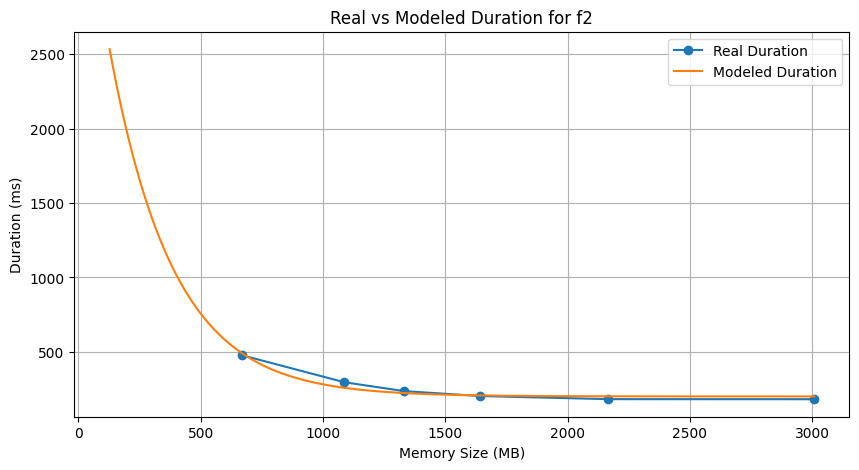

In [ ]:
# Real vs Modeled Duration
plt.figure(figsize=(10, 5))
plt.plot(logs['Memory Size'], logs['Duration'], label='Real Duration', marker='o')
plt.plot(memory_space, modeled_duration, label='Modeled Duration')
plt.xlabel('Memory Size (MB)')
plt.ylabel('Duration (ms)')
plt.title(f'Real vs Modeled Duration for {function_name}')
plt.legend()
plt.grid()

plt.show()

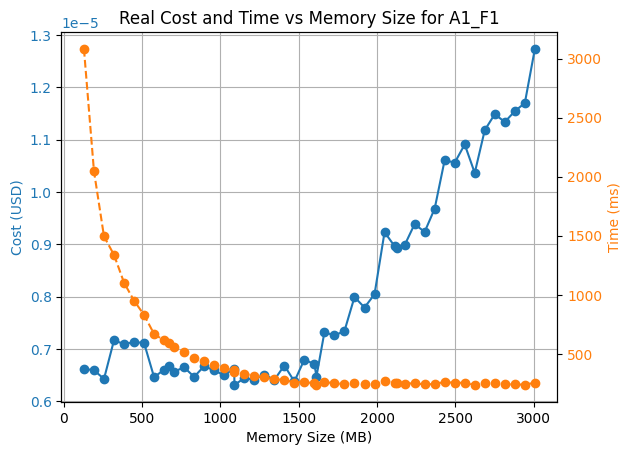

In [14]:
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot Cost on the primary y-axis
ax1.set_xlabel('Memory Size (MB)')
ax1.set_ylabel('Cost (USD)', color='tab:blue')
ax1.plot(logs['Memory Size'], logs['Cost'], color='tab:blue', marker='o', label='Cost')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Time
ax2 = ax1.twinx()
ax2.set_ylabel('Time (ms)', color='tab:orange')
ax2.plot(logs['Memory Size'], logs['Duration'], color='tab:orange', marker='o', linestyle='--', label='Time')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and grid
plt.title('Real Cost and Time vs Memory Size for ' + function_name)
ax1.grid(True)

# Show plot
plt.show()

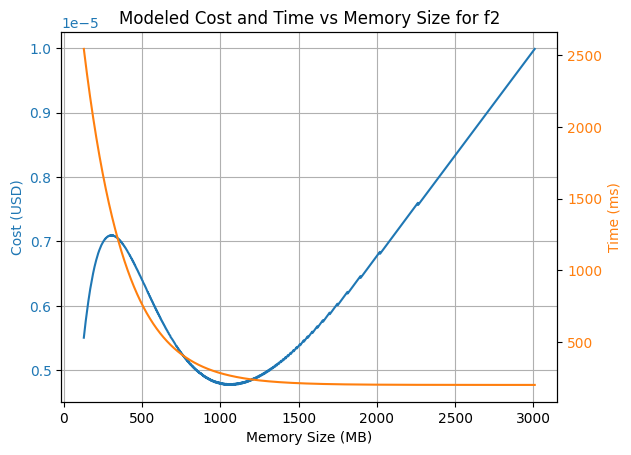

In [9]:
# Create figure and axis objects
fig, ax1 = plt.subplots()


# Plot Cost on the primary y-axis
ax1.set_xlabel('Memory Size (MB)')
ax1.set_ylabel('Cost (USD)', color='tab:blue')
ax1.plot(memory_space, modeled_cost, color='tab:blue', label='Cost')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Time
ax2 = ax1.twinx()
ax2.set_ylabel('Time (ms)', color='tab:orange')
ax2.plot(memory_space, modeled_duration, color='tab:orange', label='Time')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and grid
plt.title('Modeled Cost and Time vs Memory Size for ' + function_name)
ax1.grid(True)

# Show plot
plt.show()